# Imports

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns
import cv2

# Load Data

In [3]:
with open(os.path.join(os.path.dirname(os.getcwd()), 'data', 'probe_labels.json')) as f:
    data = json.load(f)

annotations = data['annotations']
images_info = {img['id']: img for img in data['images']}

annotations = data['annotations']
images = data['images']

annotations_df = pd.DataFrame(annotations)
images_df = pd.DataFrame(images)

In [4]:
# Merge annotations with image info
merged_df = annotations_df.merge(images_df, left_on='image_id', right_on='id')
merged_df = merged_df[['id', 'file_name', 'bbox', 'height', 'width']]
merged_df.head()

,id,file_name,bbox,height,width
0,0,E300PREMP00002_00725_216_1flight_300_2.jpg,"[90.0, 0.0, 133.0, 208.0]",400,640
1,1,E300PREMP00002_00725_216_1flight_900_2.jpg,"[90.0, 0.0, 133.0, 208.0]",400,640
2,2,E300PREMP00002_00725_216_1flight_1500_2.jpg,"[90.0, 0.0, 133.0, 208.0]",400,640
3,3,E300PREMP00002_00725_216_1flight_2100_2.jpg,"[90.0, 0.0, 133.0, 208.0]",400,640
4,4,E300PREMP00002_00725_216_1flight_2700_2.jpg,"[90.0, 0.0, 133.0, 208.0]",400,640


# Test Box coordinates before Processing dataset

In [5]:
def plot_bounding_box(row, is_center=False):
    """
    Plots the bounding box on the image.
    
    :param row: A DataFrame row.
    :param is_center: Boolean indicating if the bbox should be treated as center-based.
    """
    image_path =  os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw_images', row['file_name'])
    
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        return
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    if is_center:
        # Convert center-based bbox to corner-based
        x_center, y_center, width, height = row['bbox'] 
        x = x_center - width / 2
        y = y_center - height / 2
    else:
        # Assume bbox is corner-based
        x_min, y_min, width, height = row['bbox']
        x = x_min
        y = y_min
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    plt.title(f"Image ID: {row['id']} - {row['file_name']}")
    plt.show()

In [6]:
def visualize_sample_bounding_boxes(merged_df, sample_size=5):
    """
    Visualizes bounding boxes.
    
    :param merged_df: pandas DataFrame containing merged annotations and image info.
    :param sample_size: Number of unique images to visualize.
    """
    # Select a random sample of unique image IDs
    unique_image_ids = merged_df['id'].unique()
    sampled_ids = np.random.choice(unique_image_ids, size=sample_size, replace=False)
    
    for img_id in sampled_ids:
        # Filter rows corresponding to the current image ID
        img_annotations = merged_df[merged_df['id'] == img_id]
        
        # Fetch image information from the first row (since all rows have the same image info)
        img_info = img_annotations.iloc[0]
        
        print(f"Visualizing {img_info['file_name']} with {len(img_annotations)} bounding box(es)")
        
        # Plot each bounding box on the image
        for _, row in img_annotations.iterrows():
            # Visualize assuming the bbox is corner-based
            print("Assuming bbox is corner-based:")
            plot_bounding_box(row, is_center=False)
            
            # visualize assuming the bbox is center-based
            print("Assuming bbox is center-based:")
            plot_bounding_box(row, is_center=True)
            print()

Visualizing E300PREMP00002_00727_218_1flight_0_2.jpg with 1 bounding box(es)
Assuming bbox is corner-based:


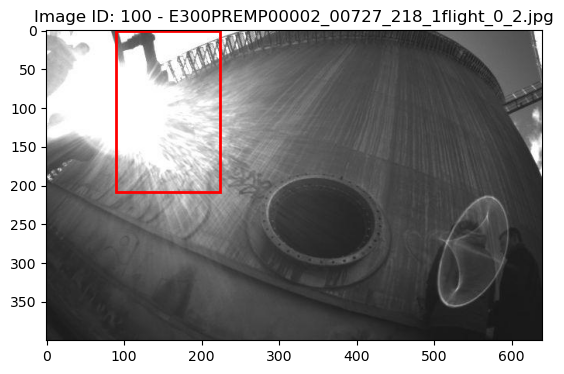

Assuming bbox is center-based:


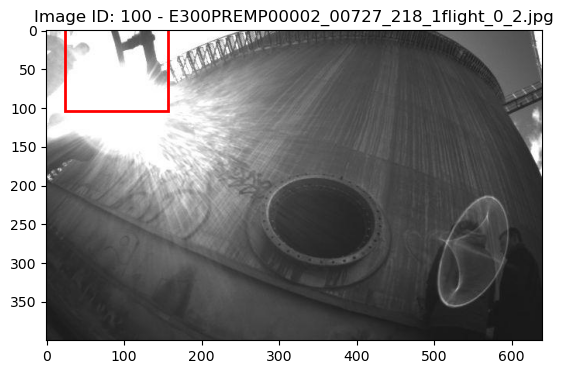


Visualizing EL300858804493_00330_112_1flight_1200_2.jpg with 1 bounding box(es)
Assuming bbox is corner-based:


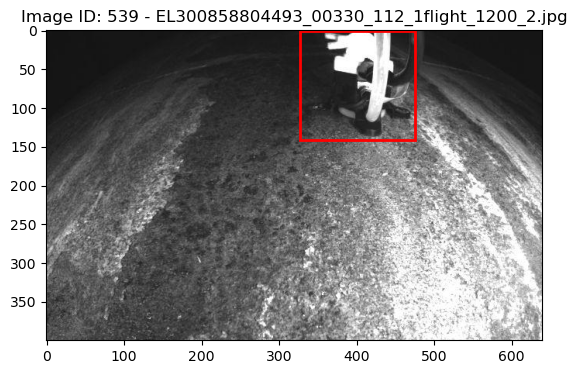

Assuming bbox is center-based:


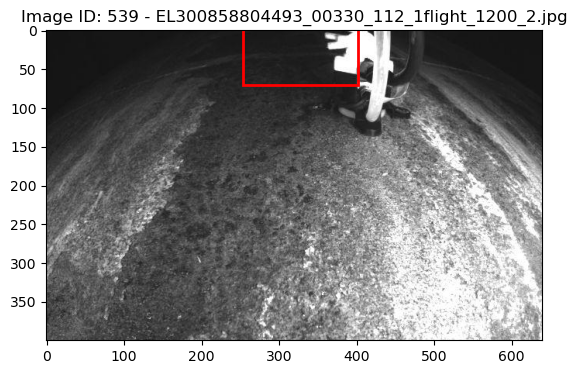


Visualizing E300SA23130257_00053_034_1flight_4800_0.jpg with 1 bounding box(es)
Assuming bbox is corner-based:


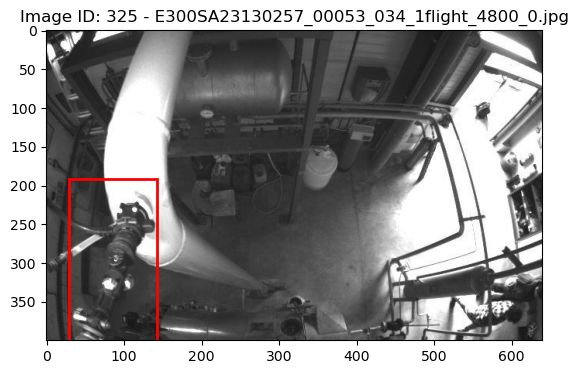

Assuming bbox is center-based:


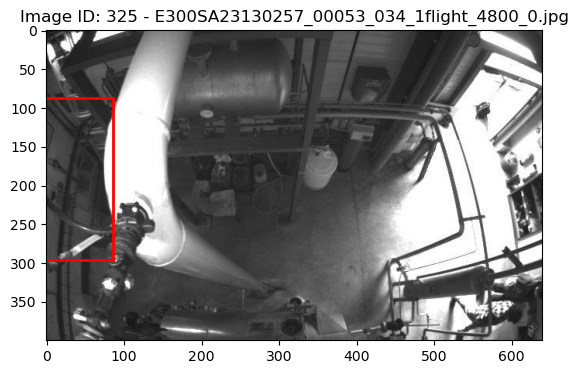

In [7]:
visualize_sample_bounding_boxes(merged_df, sample_size=3)

# Bounding Box Size Distribution

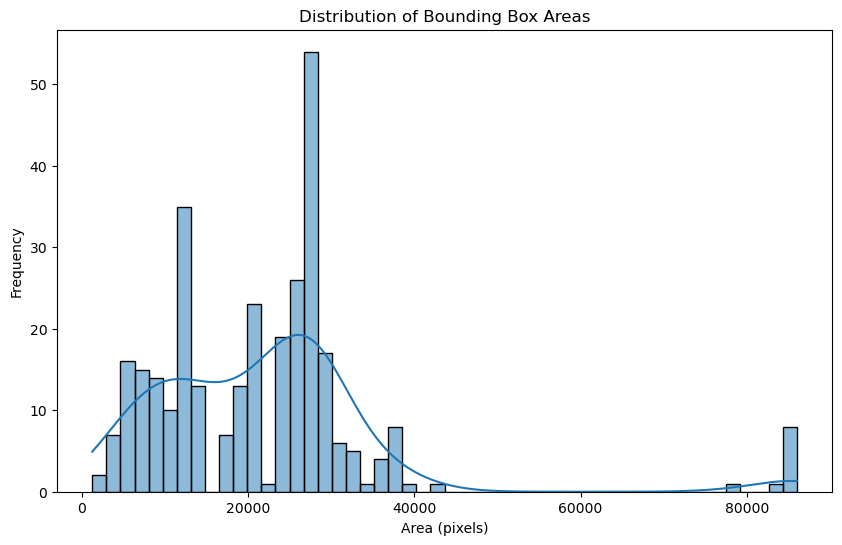

In [8]:
# Calculate bounding box areas
merged_df['bbox_area'] = merged_df['bbox'].apply(lambda x: x[2] * x[3])

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['bbox_area'], bins=50, kde=True)
plt.title('Distribution of Bounding Box Areas')
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.show()

# Box Coordinated Distribution

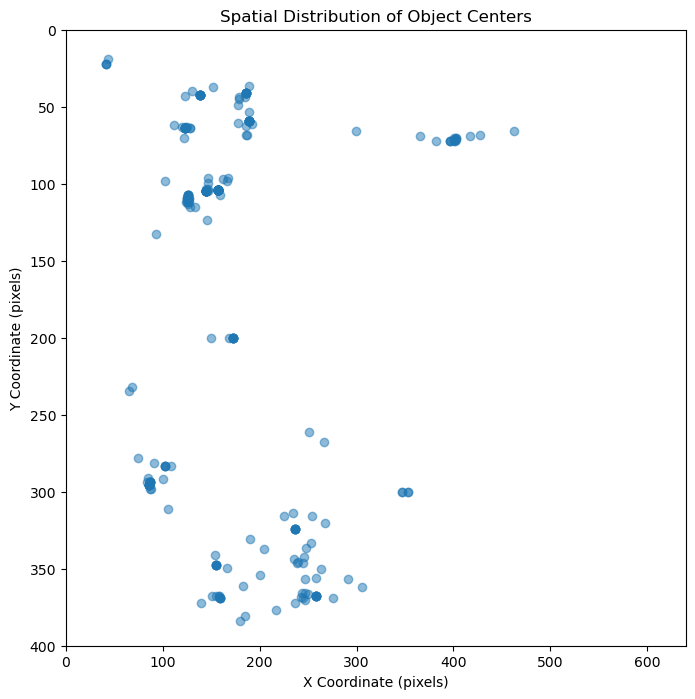

In [9]:
# Calculate centers
merged_df['x_center'] = merged_df['bbox'].apply(lambda x: x[0] + x[2]/2)
merged_df['y_center'] = merged_df['bbox'].apply(lambda x: x[1] + x[3]/2)

plt.figure(figsize=(8, 8))
plt.scatter(merged_df['x_center'], merged_df['y_center'], alpha=0.5)
plt.title('Spatial Distribution of Object Centers')
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.xlim(0, merged_df['width'].max())
plt.ylim(0, merged_df['height'].max())
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.show()

The model can tend to be more biased when detecting probes in the same regions, so we should use data augmentation (cropping, shifting, ...) to distribute objects more uniformly

# Image Resolution Analysis

       width  height
count  308.0   308.0
mean   640.0   400.0
std      0.0     0.0
min    640.0   400.0
25%    640.0   400.0
50%    640.0   400.0
75%    640.0   400.0
max    640.0   400.0


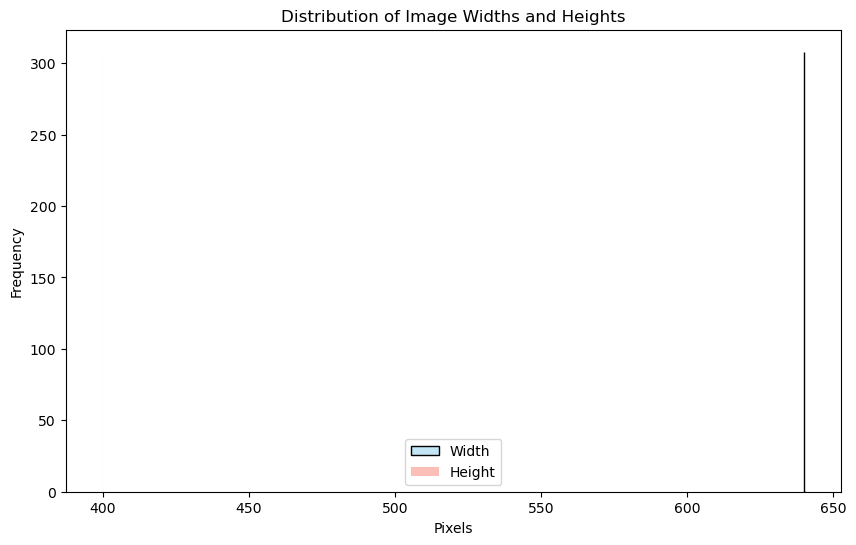

In [10]:
# Check for resolution consistency
print(images_df[['width', 'height']].describe())

# Plot resolution distribution if variable
plt.figure(figsize=(10, 6))
sns.histplot(images_df['width'], bins=50, kde=True, color='skyblue', label='Width')
sns.histplot(images_df['height'], bins=50, kde=True, color='salmon', label='Height')
plt.title('Distribution of Image Widths and Heights')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Study The Contrast of Images

In [33]:
def calculate_contrast(image):
    """Calculate the contrast of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = gray.max() - gray.min()
    return contrast

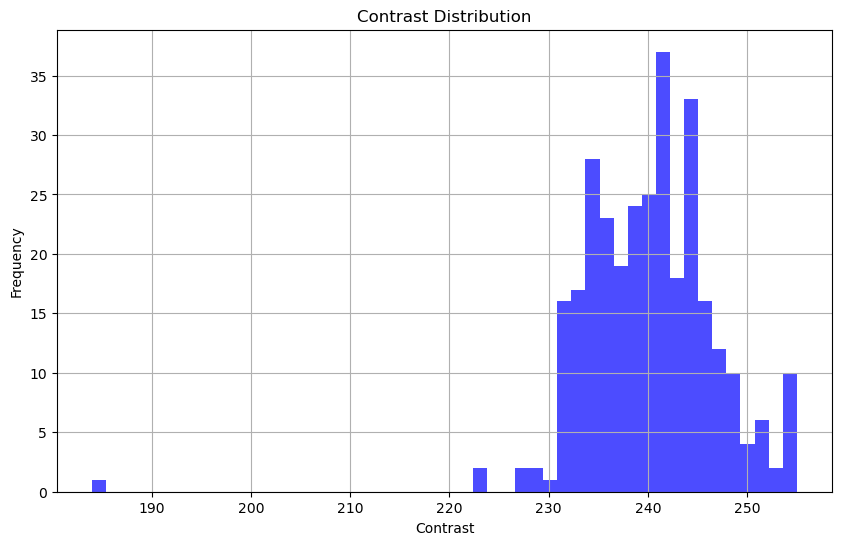

In [34]:
raw_images_folder = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw_images')
contrasts = []
images = []

for filename in os.listdir(raw_images_folder):
    img_path = os.path.join(raw_images_folder, filename)
    image = cv2.imread(img_path)

    if image is not None:
        contrast = calculate_contrast(image)
        contrasts.append(contrast)
        images.append(image)

# Plotting the distribution of contrast
plt.figure(figsize=(10, 6))
plt.hist(contrasts, bins=50, color='blue', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.grid()
plt.show()

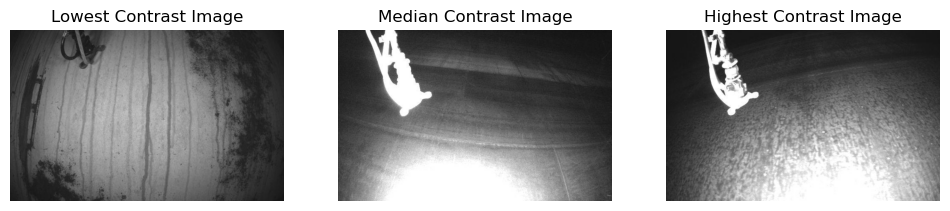

In [35]:
# Find the indices of the lowest, median and highest contrast images
lowest_contrast_index = np.argmin(contrasts)
highest_contrast_index = np.argmax(contrasts)

median_contrast_value = np.median(contrasts)
median_contrast_index = contrasts.index(median_contrast_value)

plt.figure(figsize=(12, 6))
# Lowest contrast image
plt.subplot(1, 3, 1)
plt.imshow(images[lowest_contrast_index])
plt.title('Lowest Contrast Image')
plt.axis('off')

# Median contrast image
plt.subplot(1, 3, 2)
plt.imshow(images[median_contrast_index])
plt.title('Median Contrast Image')
plt.axis('off')

# Highest contrast image
plt.subplot(1, 3, 3)
plt.imshow(images[highest_contrast_index])
plt.title('Highest Contrast Image')
plt.axis('off')

plt.show()

### Change contrast of dataset

In [36]:
def adjust_contrast(image, target_contrast):
    """Adjust the contrast of an image to the target contrast level."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    current_contrast = gray.max() - gray.min()
    
    if current_contrast == 0:
        return image
    
    # Scale factor to achieve the target contrast
    scale_factor = target_contrast / current_contrast
    adjusted_image = cv2.convertScaleAbs(image, alpha=scale_factor, beta=0)
    
    return adjusted_image

In [61]:
def change_contrast_in_dataset(folder_path, target_contrast=255):
    """Change the contrast of images in the dataset to the target contrast level."""
    adjusted_images = []
    original_images = []
    image_names = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)

        if image is not None:
            adjusted_image = adjust_contrast(image, target_contrast)
            adjusted_images.append(adjusted_image)
            original_images.append(image)
            image_names.append(filename)

    num_examples = 5
    plt.figure(figsize=(15, 6))

    for i in range(num_examples):
        # Original image
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(original_images[i])
        plt.title('Original')
        plt.axis('off')

        # Adjusted image
        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(adjusted_images[i])
        plt.title('Adjusted')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

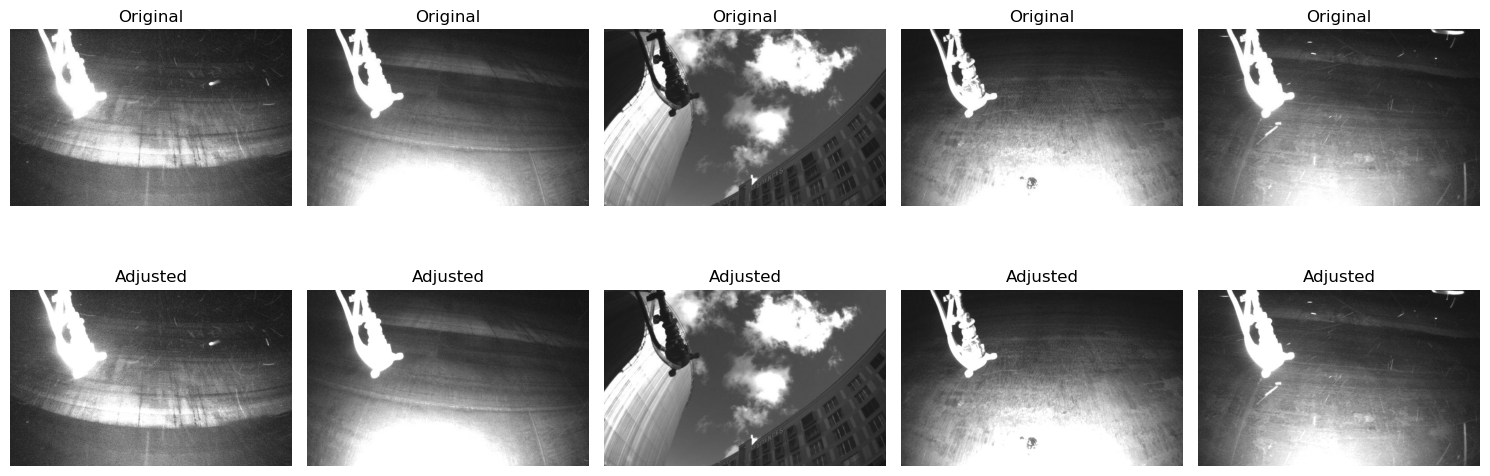

In [62]:
change_contrast_in_dataset(raw_images_folder)